# Classifier using LSTM layers

## 1. Importing Libraries

In [1]:
import torch

import pennylane as qml
import numpy as np
import pandas as pd

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 40

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [2]:
import os


def get_categories_from_data(folder, n=None):
    categories = []
    files = os.listdir(folder)

    for file in files:
        fname = file[16:-7]
        if len(fname) > 0:
            categories.append(fname)

    if n is None:
        return categories
    
    return categories[:n]

classes = get_categories_from_data(data_folder)
class_id = dict(zip(classes, range(len(classes))))


camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'camera': 0, 'cell phone': 1}

In [3]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes
    
    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)
    
    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]
    
    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0
    
    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]
    
    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)


# TODO: Limitar dataset
resized_cellphone_drawings = resized_cellphone_drawings[:5000]
resized_camera_drawings = resized_camera_drawings[:5000]

resized_camera_drawings.shape, resized_cellphone_drawings.shape

((5000, 95, 3), (5000, 95, 3))

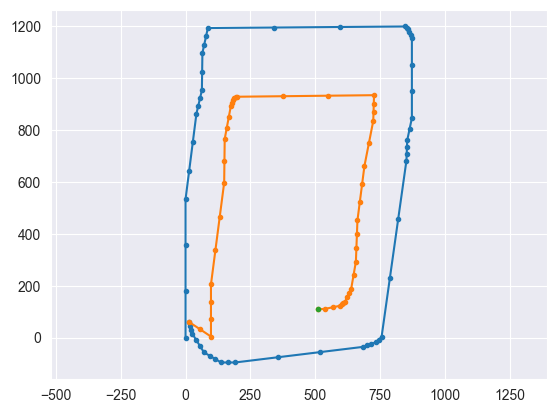

In [4]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()
    
    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()
    
draw_strokes(resized_cellphone_drawings[0])

In [5]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras and cellphones.
    
    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    test_size (float): The proportion of the dataset to include in the test split.
    
    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    # Labels for the datasets
    camera_labels = np.zeros(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0])
    
    # Combine the drawings from both categories
    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels], axis=0)
    
    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, test_size=0.2)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 95, 3), (8000,), (2000, 95, 3), (2000,))

In [7]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.
    
    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    # Convert numpy arrays to TensorFlow tensors
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))
    
    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

# Setup DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
print(len(train_loader))
print(len(test_loader))

200
50


## 3. Model Building

### 3.1. Quantum Layer

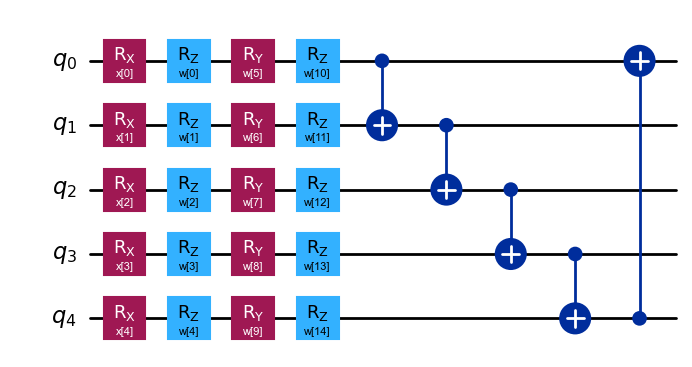

In [13]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN (
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=3, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        
        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)
        
        # Quantum layer
        self.fc3 = nn.Linear(64, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])
        
        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)
        
        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        
        # Pool layer
        x = self.pool3(x)
        
        # Flatten the output for dense layer
        x = torch.flatten(x, 1)
        
        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)
        
        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [15]:
checkpoint_filepath = 'models/quantum_lstm/best_model_weights.pth'

In [16]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            
            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
loss_list = [] 
val_accuracy_list = []

for epoch in range(100):
    model.train()
    
    total_loss = []
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()
        
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        
        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        
        total_samples += 1
        
    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    
    loss_list.append(sum(total_loss) / len(train_loader))
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')
    
    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 200/200 [02:47<00:00,  1.20it/s]


Epoch 1, Accuracy: 0.80375, Loss: 0.610671048462391, Validation Accuracy: 0.923, Validation Loss: 0.5357987284660339


100%|██████████| 200/200 [02:47<00:00,  1.19it/s]


Epoch 2, Accuracy: 0.928125, Loss: 0.478837453275919, Validation Accuracy: 0.949, Validation Loss: 0.4163338840007782


100%|██████████| 200/200 [02:48<00:00,  1.19it/s]


Epoch 3, Accuracy: 0.95125, Loss: 0.3718057432770729, Validation Accuracy: 0.9685, Validation Loss: 0.3179774284362793


100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch 4, Accuracy: 0.958125, Loss: 0.29606018275022505, Validation Accuracy: 0.9715, Validation Loss: 0.24971552193164825


100%|██████████| 200/200 [03:57<00:00,  1.19s/it]


Epoch 5, Accuracy: 0.967875, Loss: 0.23155311413109303, Validation Accuracy: 0.9765, Validation Loss: 0.19559669494628906


100%|██████████| 200/200 [03:32<00:00,  1.06s/it]


Epoch 6, Accuracy: 0.97275, Loss: 0.1863175852224231, Validation Accuracy: 0.975, Validation Loss: 0.16586875915527344


100%|██████████| 200/200 [02:55<00:00,  1.14it/s]


Epoch 7, Accuracy: 0.97525, Loss: 0.15827076982706786, Validation Accuracy: 0.9825, Validation Loss: 0.13024239242076874


100%|██████████| 200/200 [02:51<00:00,  1.16it/s]


Epoch 8, Accuracy: 0.980125, Loss: 0.12883709024637938, Validation Accuracy: 0.984, Validation Loss: 0.10816612839698792


100%|██████████| 200/200 [06:18<00:00,  1.89s/it]


Epoch 9, Accuracy: 0.980625, Loss: 0.11416382111608982, Validation Accuracy: 0.9845, Validation Loss: 0.09705149382352829


100%|██████████| 200/200 [02:49<00:00,  1.18it/s]


Epoch 10, Accuracy: 0.98125, Loss: 0.10036111326888203, Validation Accuracy: 0.9825, Validation Loss: 0.09529908001422882


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 11, Accuracy: 0.982125, Loss: 0.0930918893404305, Validation Accuracy: 0.984, Validation Loss: 0.08004958927631378


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 12, Accuracy: 0.98075, Loss: 0.0878584044612944, Validation Accuracy: 0.9805, Validation Loss: 0.08001735806465149


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 13, Accuracy: 0.985, Loss: 0.07325349140912295, Validation Accuracy: 0.987, Validation Loss: 0.067142054438591


100%|██████████| 200/200 [02:47<00:00,  1.20it/s]


Epoch 14, Accuracy: 0.986875, Loss: 0.06447785775177181, Validation Accuracy: 0.986, Validation Loss: 0.06570790708065033


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 15, Accuracy: 0.990125, Loss: 0.05416807390749454, Validation Accuracy: 0.9835, Validation Loss: 0.061000995337963104


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 16, Accuracy: 0.9885, Loss: 0.05338988211005926, Validation Accuracy: 0.9815, Validation Loss: 0.06511552631855011


100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch 17, Accuracy: 0.99, Loss: 0.05021220807917416, Validation Accuracy: 0.982, Validation Loss: 0.06299300491809845


100%|██████████| 200/200 [02:53<00:00,  1.15it/s]


Epoch 18, Accuracy: 0.99125, Loss: 0.04527317891828716, Validation Accuracy: 0.978, Validation Loss: 0.07381373643875122


100%|██████████| 200/200 [02:48<00:00,  1.19it/s]


Epoch 19, Accuracy: 0.991625, Loss: 0.04266821898519993, Validation Accuracy: 0.9905, Validation Loss: 0.04407723993062973


100%|██████████| 200/200 [02:48<00:00,  1.19it/s]


Epoch 20, Accuracy: 0.991625, Loss: 0.04233353342860937, Validation Accuracy: 0.988, Validation Loss: 0.051317233592271805


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 21, Accuracy: 0.9905, Loss: 0.04222301254980266, Validation Accuracy: 0.979, Validation Loss: 0.065503790974617


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 22, Accuracy: 0.990875, Loss: 0.03879333324264735, Validation Accuracy: 0.984, Validation Loss: 0.053546272218227386


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 23, Accuracy: 0.992375, Loss: 0.03413093564566225, Validation Accuracy: 0.9825, Validation Loss: 0.059735432267189026


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 24, Accuracy: 0.992375, Loss: 0.03281518110539764, Validation Accuracy: 0.986, Validation Loss: 0.048308998346328735


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 25, Accuracy: 0.9965, Loss: 0.021162524721585214, Validation Accuracy: 0.986, Validation Loss: 0.05135883018374443


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 26, Accuracy: 0.991625, Loss: 0.03427494299132377, Validation Accuracy: 0.985, Validation Loss: 0.05299727991223335


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 27, Accuracy: 0.9945, Loss: 0.024763728147372602, Validation Accuracy: 0.9845, Validation Loss: 0.04671390354633331


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 28, Accuracy: 0.99375, Loss: 0.02423959529027343, Validation Accuracy: 0.985, Validation Loss: 0.04963257908821106


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 29, Accuracy: 0.996, Loss: 0.018183357531670483, Validation Accuracy: 0.987, Validation Loss: 0.046513885259628296


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 30, Accuracy: 0.995125, Loss: 0.021916824341751635, Validation Accuracy: 0.9815, Validation Loss: 0.06568066775798798


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 31, Accuracy: 0.997125, Loss: 0.016551461045164615, Validation Accuracy: 0.987, Validation Loss: 0.05131050571799278


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 32, Accuracy: 0.996125, Loss: 0.020668507176451384, Validation Accuracy: 0.9855, Validation Loss: 0.05166257917881012


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 33, Accuracy: 0.993125, Loss: 0.02433630302315578, Validation Accuracy: 0.9865, Validation Loss: 0.0448450893163681


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 34, Accuracy: 0.995125, Loss: 0.019617580303456634, Validation Accuracy: 0.9785, Validation Loss: 0.06572530418634415


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 35, Accuracy: 0.995375, Loss: 0.018336519866716118, Validation Accuracy: 0.981, Validation Loss: 0.06296462565660477


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 36, Accuracy: 0.99625, Loss: 0.016075232478324323, Validation Accuracy: 0.988, Validation Loss: 0.04535951465368271


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 37, Accuracy: 0.99575, Loss: 0.014785258383490145, Validation Accuracy: 0.9895, Validation Loss: 0.04042193293571472


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 38, Accuracy: 0.997, Loss: 0.012882152667734771, Validation Accuracy: 0.9845, Validation Loss: 0.056796297430992126


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 39, Accuracy: 0.995875, Loss: 0.015841824698727577, Validation Accuracy: 0.9865, Validation Loss: 0.05111178010702133


100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


Epoch 40, Accuracy: 0.994875, Loss: 0.021432176748057828, Validation Accuracy: 0.9825, Validation Loss: 0.057525113224983215


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 41, Accuracy: 0.99725, Loss: 0.013551153271691874, Validation Accuracy: 0.9865, Validation Loss: 0.04686858505010605


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 42, Accuracy: 0.996875, Loss: 0.012983643520856276, Validation Accuracy: 0.9845, Validation Loss: 0.05358470603823662


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 43, Accuracy: 0.996125, Loss: 0.01626638475805521, Validation Accuracy: 0.9865, Validation Loss: 0.04776196554303169


100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


Epoch 44, Accuracy: 0.997125, Loss: 0.014024703005561604, Validation Accuracy: 0.9845, Validation Loss: 0.05509587377309799


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 45, Accuracy: 0.997625, Loss: 0.011024448552634568, Validation Accuracy: 0.9885, Validation Loss: 0.04022061824798584


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 46, Accuracy: 0.997875, Loss: 0.010625995062291622, Validation Accuracy: 0.9915, Validation Loss: 0.03684311732649803


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 47, Accuracy: 0.9965, Loss: 0.013179799302015453, Validation Accuracy: 0.986, Validation Loss: 0.0477423332631588


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 48, Accuracy: 0.997625, Loss: 0.011301430048188194, Validation Accuracy: 0.989, Validation Loss: 0.037151895463466644


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 49, Accuracy: 0.9985, Loss: 0.008838873303029687, Validation Accuracy: 0.988, Validation Loss: 0.043969497084617615


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 50, Accuracy: 0.999125, Loss: 0.006285814405418933, Validation Accuracy: 0.988, Validation Loss: 0.04585200920701027


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 51, Accuracy: 0.9975, Loss: 0.01095056174090132, Validation Accuracy: 0.983, Validation Loss: 0.06563470512628555


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 52, Accuracy: 0.995625, Loss: 0.015264043937204406, Validation Accuracy: 0.9885, Validation Loss: 0.04189654812216759


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 53, Accuracy: 0.99625, Loss: 0.014311992868897505, Validation Accuracy: 0.987, Validation Loss: 0.04344366490840912


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 54, Accuracy: 0.99575, Loss: 0.018228513496578672, Validation Accuracy: 0.9855, Validation Loss: 0.04384918510913849


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 55, Accuracy: 0.99825, Loss: 0.00919841873634141, Validation Accuracy: 0.986, Validation Loss: 0.04697144031524658


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 56, Accuracy: 0.99625, Loss: 0.014740045321523211, Validation Accuracy: 0.988, Validation Loss: 0.048579420894384384


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 57, Accuracy: 0.998, Loss: 0.010318041010759772, Validation Accuracy: 0.9835, Validation Loss: 0.0741252526640892


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 58, Accuracy: 0.9965, Loss: 0.01379342365951743, Validation Accuracy: 0.983, Validation Loss: 0.06282400339841843


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 59, Accuracy: 0.996625, Loss: 0.01266691310564056, Validation Accuracy: 0.9865, Validation Loss: 0.04868582636117935


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 60, Accuracy: 0.999375, Loss: 0.0048909625702071935, Validation Accuracy: 0.988, Validation Loss: 0.04287831485271454


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 61, Accuracy: 0.998375, Loss: 0.007683317068731412, Validation Accuracy: 0.9845, Validation Loss: 0.06278771907091141


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 62, Accuracy: 0.99725, Loss: 0.009503652388812043, Validation Accuracy: 0.98, Validation Loss: 0.07303135097026825


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 63, Accuracy: 0.998625, Loss: 0.007512403402943164, Validation Accuracy: 0.984, Validation Loss: 0.06214892491698265


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 64, Accuracy: 0.999125, Loss: 0.005245950285461732, Validation Accuracy: 0.9885, Validation Loss: 0.04001704230904579


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 65, Accuracy: 0.999375, Loss: 0.005980751902097836, Validation Accuracy: 0.987, Validation Loss: 0.0462876595556736


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 66, Accuracy: 0.9995, Loss: 0.004250029402901419, Validation Accuracy: 0.987, Validation Loss: 0.054974135011434555


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 67, Accuracy: 0.995875, Loss: 0.017900362794753166, Validation Accuracy: 0.9765, Validation Loss: 0.08189275860786438


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 68, Accuracy: 0.991125, Loss: 0.03150814369262662, Validation Accuracy: 0.9855, Validation Loss: 0.0535278357565403


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 69, Accuracy: 0.997875, Loss: 0.010089274194324389, Validation Accuracy: 0.9855, Validation Loss: 0.05833010375499725


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 70, Accuracy: 0.9965, Loss: 0.01250490776496008, Validation Accuracy: 0.9835, Validation Loss: 0.055075131356716156


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 71, Accuracy: 0.998, Loss: 0.008294212570763192, Validation Accuracy: 0.9855, Validation Loss: 0.05379438027739525


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 72, Accuracy: 0.996875, Loss: 0.010709591117920353, Validation Accuracy: 0.9845, Validation Loss: 0.05709858983755112


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 73, Accuracy: 0.997875, Loss: 0.008843019393389114, Validation Accuracy: 0.988, Validation Loss: 0.0431956946849823


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 74, Accuracy: 0.999125, Loss: 0.005290170696680434, Validation Accuracy: 0.987, Validation Loss: 0.05288591980934143


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 75, Accuracy: 0.99925, Loss: 0.0045176853757584465, Validation Accuracy: 0.989, Validation Loss: 0.04326965659856796


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 76, Accuracy: 0.999375, Loss: 0.004255360318347811, Validation Accuracy: 0.988, Validation Loss: 0.056833066046237946


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 77, Accuracy: 0.99925, Loss: 0.005541355912573636, Validation Accuracy: 0.985, Validation Loss: 0.06969723105430603


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 78, Accuracy: 0.998125, Loss: 0.01028708872036077, Validation Accuracy: 0.987, Validation Loss: 0.039446014910936356


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 79, Accuracy: 0.99475, Loss: 0.016277516214177012, Validation Accuracy: 0.9825, Validation Loss: 0.05611823499202728


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 80, Accuracy: 0.998, Loss: 0.008913460230687634, Validation Accuracy: 0.987, Validation Loss: 0.04396903142333031


100%|██████████| 200/200 [02:47<00:00,  1.20it/s]


Epoch 81, Accuracy: 0.999375, Loss: 0.004304048753110692, Validation Accuracy: 0.9845, Validation Loss: 0.05964282900094986


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 82, Accuracy: 0.99925, Loss: 0.005160236684605479, Validation Accuracy: 0.985, Validation Loss: 0.05316966027021408


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 83, Accuracy: 0.99925, Loss: 0.005032905607949942, Validation Accuracy: 0.9875, Validation Loss: 0.05387868732213974


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 84, Accuracy: 0.997375, Loss: 0.013597476669528987, Validation Accuracy: 0.9865, Validation Loss: 0.058821726590394974


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 85, Accuracy: 0.998875, Loss: 0.005969724478200078, Validation Accuracy: 0.9865, Validation Loss: 0.051196206361055374


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 86, Accuracy: 0.99875, Loss: 0.006475965385034215, Validation Accuracy: 0.9855, Validation Loss: 0.06690777838230133


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 87, Accuracy: 0.997, Loss: 0.011446473992837127, Validation Accuracy: 0.981, Validation Loss: 0.07997620850801468


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 88, Accuracy: 0.997375, Loss: 0.009603442466177512, Validation Accuracy: 0.9725, Validation Loss: 0.11154801398515701


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 89, Accuracy: 0.998375, Loss: 0.008526170644036029, Validation Accuracy: 0.984, Validation Loss: 0.058677662163972855


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 90, Accuracy: 0.998125, Loss: 0.00872472331218887, Validation Accuracy: 0.986, Validation Loss: 0.05038183182477951


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 91, Accuracy: 0.998, Loss: 0.008595601081615313, Validation Accuracy: 0.986, Validation Loss: 0.05548250675201416


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 92, Accuracy: 0.999, Loss: 0.006042461273609661, Validation Accuracy: 0.987, Validation Loss: 0.054406099021434784


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 93, Accuracy: 0.99825, Loss: 0.008276405317010358, Validation Accuracy: 0.988, Validation Loss: 0.04565465450286865


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 94, Accuracy: 0.9975, Loss: 0.008382860293495468, Validation Accuracy: 0.9885, Validation Loss: 0.0492372140288353


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 95, Accuracy: 0.99925, Loss: 0.0046657233213773, Validation Accuracy: 0.99, Validation Loss: 0.050946060568094254


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Epoch 96, Accuracy: 0.999125, Loss: 0.006380433024605736, Validation Accuracy: 0.988, Validation Loss: 0.05376245453953743


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 97, Accuracy: 0.998625, Loss: 0.006287794376257807, Validation Accuracy: 0.985, Validation Loss: 0.06013405695557594


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 98, Accuracy: 0.998875, Loss: 0.005209401583415456, Validation Accuracy: 0.9845, Validation Loss: 0.07114671915769577


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 99, Accuracy: 0.998125, Loss: 0.009513071340334136, Validation Accuracy: 0.9875, Validation Loss: 0.058802053332328796


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 100, Accuracy: 0.998125, Loss: 0.01019392144837184, Validation Accuracy: 0.987, Validation Loss: 0.05180859565734863


## 5. Model Evaluation

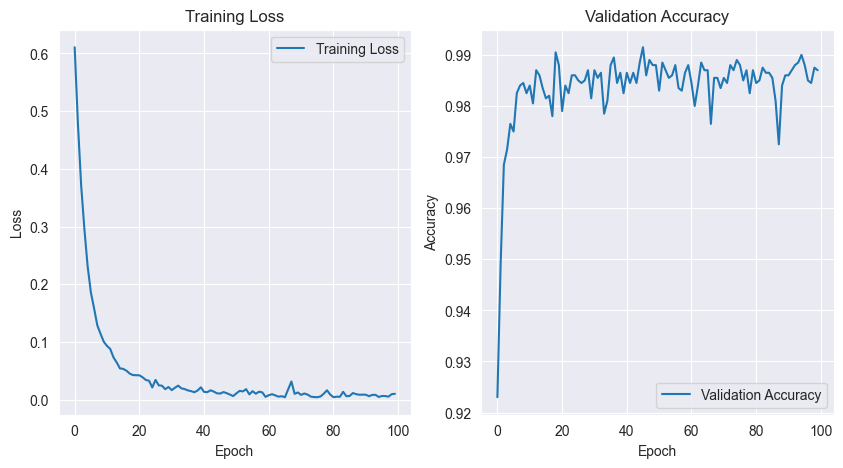

In [18]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
# plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [19]:
nn = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)
y_pred = nn.predict(X_test)

In [20]:
pred = np.argmax(y_pred.data, axis=1)

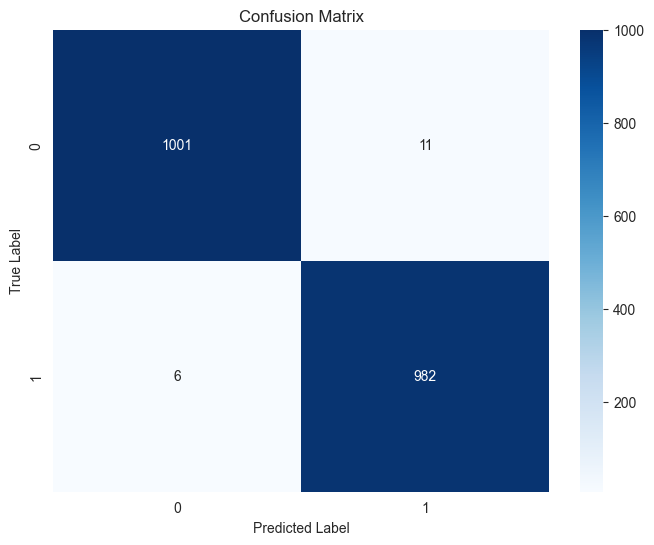

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test.astype(np.int8), np.argmax(y_pred, axis=1))